In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 5)
Dimension - total coordinates:  (6000, 55)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 55, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [26]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='valid', activation='relu',
                                     name='convLayer')(input_coord)
    #x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_conv1)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [27]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 1, 54, 400)   2000        ['input_4[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 21600)        0           ['convLayer[0][0]']              
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [29]:
model_directory = "D:\\TrainedModels\\20230102\\3Case(131415)Valid"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [30]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_3Case(131415)Valid_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [31]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [32]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1635 - rmse: 0.4041  
Epoch 1: val_loss improved from inf to 0.12772, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 16s 92ms/step - loss: 0.1584 - rmse: 0.3979 - val_loss: 0.1277 - val_rmse: 0.3572 - lr: 1.0000e-04
Epoch 2/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0821 - rmse: 0.2863
Epoch 2: val_loss improved from 0.12772 to 0.07166, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 45ms/step - loss: 0.0764 - rmse: 0.2761 - val_loss: 0.0717 - val_rmse: 0.2674 - lr: 1.0000e-04
Epoch 3/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0664 - rmse: 0.2574
Epoch 3: v

10/10 [==============================] - 0s 43ms/step - loss: 0.0572 - rmse: 0.2388 - val_loss: 0.0625 - val_rmse: 0.2497 - lr: 1.0000e-04
Epoch 24/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0587 - rmse: 0.2419
Epoch 24: val_loss did not improve from 0.06248
10/10 [==============================] - 0s 13ms/step - loss: 0.0558 - rmse: 0.2360 - val_loss: 0.0632 - val_rmse: 0.2510 - lr: 1.0000e-04
Epoch 25/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0595 - rmse: 0.2436
Epoch 25: val_loss improved from 0.06248 to 0.06232, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 37ms/step - loss: 0.0581 - rmse: 0.2408 - val_loss: 0.0623 - val_rmse: 0.2493 - lr: 1.0000e-04
Epoch 26/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0595 - rmse: 0.2436
Epoch 26: val_loss improved from 0.

Epoch 45/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0517 - rmse: 0.2271
Epoch 45: val_loss improved from 0.05830 to 0.05750, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 45ms/step - loss: 0.0522 - rmse: 0.2281 - val_loss: 0.0575 - val_rmse: 0.2395 - lr: 1.0000e-04
Epoch 46/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0549 - rmse: 0.2340
Epoch 46: val_loss improved from 0.05750 to 0.05743, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 46ms/step - loss: 0.0545 - rmse: 0.2331 - val_loss: 0.0574 - val_rmse: 0.2393 - lr: 1.0000e-04
Epoch 47/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0501 - rmse: 0.2235
Epoc

Epoch 83/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0027 - rmse: 0.0508
Epoch 83: val_loss improved from 0.00292 to 0.00274, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 44ms/step - loss: 0.0028 - rmse: 0.0517 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 84/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0030 - rmse: 0.0532
Epoch 84: val_loss did not improve from 0.00274
10/10 [==============================] - 0s 13ms/step - loss: 0.0029 - rmse: 0.0527 - val_loss: 0.0031 - val_rmse: 0.0541 - lr: 1.0000e-04
Epoch 85/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0028 - rmse: 0.0511
Epoch 85: val_loss improved from 0.00274 to 0.00258, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_

10/10 [==============================] - 0s 53ms/step - loss: 7.5262e-04 - rmse: 0.0247 - val_loss: 7.4114e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 126/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.6313e-04 - rmse: 0.0249
Epoch 126: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 13ms/step - loss: 7.3877e-04 - rmse: 0.0244 - val_loss: 8.0265e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 127/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.6883e-04 - rmse: 0.0229
Epoch 127: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 7.4066e-04 - rmse: 0.0245 - val_loss: 0.0010 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 128/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.6120e-04 - rmse: 0.0249
Epoch 128: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.1513e-04 - rmse: 0.0259 - val_loss: 7.4993e-04 - val_rm

Epoch 151/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.8709e-04 - rmse: 0.0212
Epoch 151: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 12ms/step - loss: 5.8156e-04 - rmse: 0.0210 - val_loss: 6.7110e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 152/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.2447e-04 - rmse: 0.0196
Epoch 152: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 12ms/step - loss: 5.5042e-04 - rmse: 0.0203 - val_loss: 5.8354e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 153/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.5171e-04 - rmse: 0.0226
Epoch 153: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 12ms/step - loss: 6.6635e-04 - rmse: 0.0230 - val_loss: 5.4278e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 154/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.5953e-04 - rmse: 0.0205
Epoch 154: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 4.8321e-04 - rmse: 0.0186
Epoch 177: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 12ms/step - loss: 4.9778e-04 - rmse: 0.0190 - val_loss: 6.2606e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 178/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.3551e-04 - rmse: 0.0200
Epoch 178: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 12ms/step - loss: 5.7001e-04 - rmse: 0.0208 - val_loss: 5.5928e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 179/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.3008e-04 - rmse: 0.0222
Epoch 179: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 12ms/step - loss: 5.9987e-04 - rmse: 0.0216 - val_loss: 5.9298e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 180/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.3361e-04 - rmse: 0.0245
Epoch 180: val_loss did not impr

Epoch 204/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8350e-04 - rmse: 0.0187
Epoch 204: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 12ms/step - loss: 4.7354e-04 - rmse: 0.0185 - val_loss: 4.6230e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 205/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9271e-04 - rmse: 0.0190
Epoch 205: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 12ms/step - loss: 4.8908e-04 - rmse: 0.0189 - val_loss: 5.2131e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 206/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3950e-04 - rmse: 0.0175
Epoch 206: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 12ms/step - loss: 4.4874e-04 - rmse: 0.0178 - val_loss: 4.9423e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 207/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0428e-04 - rmse: 0.0165
Epoch 207: val_l

Epoch 232/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9544e-04 - rmse: 0.0163
Epoch 232: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 13ms/step - loss: 3.9405e-04 - rmse: 0.0163 - val_loss: 4.9326e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 233/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7732e-04 - rmse: 0.0158
Epoch 233: val_loss improved from 0.00042 to 0.00041, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 41ms/step - loss: 3.9191e-04 - rmse: 0.0162 - val_loss: 4.1038e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 234/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8365e-04 - rmse: 0.0160
Epoch 234: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 12ms/step - loss: 3.8902e-04 - rmse: 0.0162 - va

Epoch 259/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8313e-04 - rmse: 0.0161
Epoch 259: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 13ms/step - loss: 3.7834e-04 - rmse: 0.0159 - val_loss: 4.3477e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 260/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8975e-04 - rmse: 0.0163
Epoch 260: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 12ms/step - loss: 3.9920e-04 - rmse: 0.0166 - val_loss: 4.5364e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 261/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3674e-04 - rmse: 0.0177
Epoch 261: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 13ms/step - loss: 4.3687e-04 - rmse: 0.0177 - val_loss: 4.9385e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 262/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1422e-04 - rmse: 0.0170
Epoch 262: val_l

Epoch 313/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7633e-04 - rmse: 0.0161
Epoch 313: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 3.6930e-04 - rmse: 0.0158 - val_loss: 4.1301e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 314/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7331e-04 - rmse: 0.0160
Epoch 314: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 3.6459e-04 - rmse: 0.0157 - val_loss: 4.1945e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 315/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8257e-04 - rmse: 0.0163
Epoch 315: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 4.0310e-04 - rmse: 0.0169 - val_loss: 4.5500e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 316/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9825e-04 - rmse: 0.0167
Epoch 316: val_l

Epoch 341/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9965e-04 - rmse: 0.0169
Epoch 341: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 4.1421e-04 - rmse: 0.0173 - val_loss: 3.8497e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 342/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4563e-04 - rmse: 0.0182
Epoch 342: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 4.2564e-04 - rmse: 0.0176 - val_loss: 5.8103e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 343/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8166e-04 - rmse: 0.0192
Epoch 343: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 4.9574e-04 - rmse: 0.0195 - val_loss: 4.4119e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 344/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8440e-04 - rmse: 0.0164
Epoch 344: val_l

Epoch 396/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2363e-04 - rmse: 0.0177
Epoch 396: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.2146e-04 - rmse: 0.0177 - val_loss: 3.7903e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 397/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8107e-04 - rmse: 0.0165
Epoch 397: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 3.7355e-04 - rmse: 0.0163 - val_loss: 4.0568e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 398/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5413e-04 - rmse: 0.0186
Epoch 398: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.4497e-04 - rmse: 0.0183 - val_loss: 5.1789e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 399/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2283e-04 - rmse: 0.0177
Epoch 399: val_l

Epoch 451/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9909e-04 - rmse: 0.0172
Epoch 451: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.8197e-04 - rmse: 0.0167 - val_loss: 4.3548e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 452/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6371e-04 - rmse: 0.0161
Epoch 452: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.5774e-04 - rmse: 0.0159 - val_loss: 3.6894e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 453/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4321e-04 - rmse: 0.0184
Epoch 453: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.2625e-04 - rmse: 0.0180 - val_loss: 4.8017e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 454/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6595e-04 - rmse: 0.0162
Epoch 454: val_l

Epoch 478/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.7790e-04 - rmse: 0.0218
Epoch 478: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 13ms/step - loss: 6.0919e-04 - rmse: 0.0225 - val_loss: 4.9113e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 479/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8238e-04 - rmse: 0.0195
Epoch 479: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.8111e-04 - rmse: 0.0195 - val_loss: 5.7004e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 480/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8252e-04 - rmse: 0.0195
Epoch 480: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.8806e-04 - rmse: 0.0197 - val_loss: 3.9612e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 481/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4761e-04 - rmse: 0.0157
Epoch 481: val_l

Epoch 506/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6542e-04 - rmse: 0.0191
Epoch 506: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.7027e-04 - rmse: 0.0193 - val_loss: 6.7226e-04 - val_rmse: 0.0239 - lr: 1.0000e-04
Epoch 507/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.7945e-04 - rmse: 0.0195
Epoch 507: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.6388e-04 - rmse: 0.0191 - val_loss: 4.5890e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 508/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7209e-04 - rmse: 0.0165
Epoch 508: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.6026e-04 - rmse: 0.0162 - val_loss: 4.6683e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 509/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4298e-04 - rmse: 0.0185
Epoch 509: val_l

Epoch 561/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4568e-04 - rmse: 0.0158
Epoch 561: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.4631e-04 - rmse: 0.0159 - val_loss: 3.7492e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 562/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3674e-04 - rmse: 0.0155
Epoch 562: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.4409e-04 - rmse: 0.0158 - val_loss: 3.8056e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 563/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2491e-04 - rmse: 0.0152
Epoch 563: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.0506e-04 - rmse: 0.0145 - val_loss: 3.4289e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 564/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5897e-04 - rmse: 0.0163
Epoch 564: val_l

Epoch 589/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8030e-04 - rmse: 0.0169
Epoch 589: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.7797e-04 - rmse: 0.0169 - val_loss: 3.6787e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 590/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5763e-04 - rmse: 0.0163
Epoch 590: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.6569e-04 - rmse: 0.0165 - val_loss: 4.0605e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 591/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6820e-04 - rmse: 0.0166
Epoch 591: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.6769e-04 - rmse: 0.0166 - val_loss: 4.0351e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 592/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0571e-04 - rmse: 0.0177
Epoch 592: val_l

Epoch 644/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2683e-04 - rmse: 0.0184
Epoch 644: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.9387e-04 - rmse: 0.0175 - val_loss: 3.7285e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 645/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1473e-04 - rmse: 0.0150
Epoch 645: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.1795e-04 - rmse: 0.0151 - val_loss: 3.4956e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 646/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3556e-04 - rmse: 0.0157
Epoch 646: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.3066e-04 - rmse: 0.0155 - val_loss: 3.4242e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 647/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1808e-04 - rmse: 0.0151
Epoch 647: val_l

Epoch 671/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2361e-04 - rmse: 0.0183
Epoch 671: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 4.2883e-04 - rmse: 0.0185 - val_loss: 4.9020e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 672/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9553e-04 - rmse: 0.0175
Epoch 672: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.8650e-04 - rmse: 0.0173 - val_loss: 4.4607e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 673/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2288e-04 - rmse: 0.0183
Epoch 673: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 4.0775e-04 - rmse: 0.0179 - val_loss: 3.9979e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 674/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4654e-04 - rmse: 0.0161
Epoch 674: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.7962e-04 - rmse: 0.0172
Epoch 725: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.5545e-04 - rmse: 0.0165 - val_loss: 3.4682e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 726/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8630e-04 - rmse: 0.0174
Epoch 726: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.7997e-04 - rmse: 0.0172 - val_loss: 3.7536e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 727/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7132e-04 - rmse: 0.0169
Epoch 727: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.5715e-04 - rmse: 0.0165 - val_loss: 3.7385e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 728/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4315e-04 - rmse: 0.0161
Epoch 728: val_loss did not impr

Epoch 753/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8093e-04 - rmse: 0.0173
Epoch 753: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6054e-04 - rmse: 0.0167 - val_loss: 4.4854e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 754/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4833e-04 - rmse: 0.0163
Epoch 754: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.4105e-04 - rmse: 0.0161 - val_loss: 3.8905e-04 - val_rmse: 0.0175 - lr: 1.0000e-04
Epoch 755/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3470e-04 - rmse: 0.0159
Epoch 755: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.3720e-04 - rmse: 0.0159 - val_loss: 3.9965e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 756/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6393e-04 - rmse: 0.0168
Epoch 756: val_l

Epoch 781/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6657e-04 - rmse: 0.0169
Epoch 781: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.5323e-04 - rmse: 0.0165 - val_loss: 3.4046e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 782/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6500e-04 - rmse: 0.0168
Epoch 782: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.8031e-04 - rmse: 0.0173 - val_loss: 4.6227e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 783/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6657e-04 - rmse: 0.0196
Epoch 783: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 4.6381e-04 - rmse: 0.0196 - val_loss: 3.6952e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 784/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9742e-04 - rmse: 0.0178
Epoch 784: val_l

Epoch 836/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1822e-04 - rmse: 0.0155
Epoch 836: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.4204e-04 - rmse: 0.0162 - val_loss: 4.2836e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 837/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7960e-04 - rmse: 0.0173
Epoch 837: val_loss improved from 0.00031 to 0.00030, saving model to D:\TrainedModels\20230102\3Case(131415)Valid20230102unsteady_AeroCNN1_3Case(131415)Valid_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 42ms/step - loss: 3.5113e-04 - rmse: 0.0165 - val_loss: 3.0204e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 838/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9913e-04 - rmse: 0.0148
Epoch 838: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 2.9956e-04 - rmse: 0.0149 - va

Epoch 891/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3704e-04 - rmse: 0.0161
Epoch 891: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.4319e-04 - rmse: 0.0163 - val_loss: 3.7369e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 892/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1337e-04 - rmse: 0.0154
Epoch 892: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.1878e-04 - rmse: 0.0156 - val_loss: 3.6649e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 893/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1989e-04 - rmse: 0.0156
Epoch 893: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.3348e-04 - rmse: 0.0160 - val_loss: 4.1016e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 894/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4820e-04 - rmse: 0.0165
Epoch 894: val_l

Epoch 919/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3468e-04 - rmse: 0.0161
Epoch 919: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.3816e-04 - rmse: 0.0162 - val_loss: 3.1949e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 920/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9371e-04 - rmse: 0.0148
Epoch 920: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.0491e-04 - rmse: 0.0152 - val_loss: 3.7801e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 921/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4986e-04 - rmse: 0.0166
Epoch 921: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.5769e-04 - rmse: 0.0168 - val_loss: 4.2623e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 922/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7644e-04 - rmse: 0.0174
Epoch 922: val_l

Epoch 974/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9976e-04 - rmse: 0.0151
Epoch 974: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.0036e-04 - rmse: 0.0151 - val_loss: 3.6451e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 975/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4572e-04 - rmse: 0.0165
Epoch 975: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.3808e-04 - rmse: 0.0163 - val_loss: 4.2852e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 976/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7656e-04 - rmse: 0.0174
Epoch 976: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 13ms/step - loss: 3.6775e-04 - rmse: 0.0172 - val_loss: 4.2627e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 977/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5993e-04 - rmse: 0.0169
Epoch 977: val_l

Epoch 1002/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9053e-04 - rmse: 0.0148
Epoch 1002: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 13ms/step - loss: 2.9008e-04 - rmse: 0.0148 - val_loss: 3.1890e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 1003/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4936e-04 - rmse: 0.0166
Epoch 1003: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.7897e-04 - rmse: 0.0175 - val_loss: 5.4435e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 1004/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8692e-04 - rmse: 0.0177
Epoch 1004: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.5929e-04 - rmse: 0.0169 - val_loss: 3.4998e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1005/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8703e-04 - rmse: 0.0147
Epoch 100

Epoch 1030/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9134e-04 - rmse: 0.0179
Epoch 1030: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.7150e-04 - rmse: 0.0173 - val_loss: 3.5082e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1031/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9166e-04 - rmse: 0.0179
Epoch 1031: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 4.1205e-04 - rmse: 0.0185 - val_loss: 4.5990e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 1032/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3290e-04 - rmse: 0.0190
Epoch 1032: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 4.1647e-04 - rmse: 0.0186 - val_loss: 4.9248e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 1033/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2735e-04 - rmse: 0.0189
Epoch 103

 7/10 [====================>.........] - ETA: 0s - loss: 2.7414e-04 - rmse: 0.0143
Epoch 1055: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.6694e-04 - rmse: 0.0140 - val_loss: 3.0261e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 1056/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7470e-04 - rmse: 0.0143
Epoch 1056: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.7343e-04 - rmse: 0.0142 - val_loss: 3.0657e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 1057/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8400e-04 - rmse: 0.0146
Epoch 1057: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 2.7973e-04 - rmse: 0.0145 - val_loss: 2.9845e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 1058/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9352e-04 - rmse: 0.0149
Epoch 1058: val_loss did n

 7/10 [====================>.........] - ETA: 0s - loss: 2.6348e-04 - rmse: 0.0139
Epoch 1109: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.6560e-04 - rmse: 0.0140 - val_loss: 3.1969e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 1110/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6676e-04 - rmse: 0.0140
Epoch 1110: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.6884e-04 - rmse: 0.0141 - val_loss: 3.3668e-04 - val_rmse: 0.0163 - lr: 5.0000e-05
Epoch 1111/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8453e-04 - rmse: 0.0147
Epoch 1111: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.8596e-04 - rmse: 0.0147 - val_loss: 3.2778e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 1112/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9184e-04 - rmse: 0.0149
Epoch 1112: val_loss did n

Epoch 1137/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7739e-04 - rmse: 0.0144
Epoch 1137: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.8571e-04 - rmse: 0.0147 - val_loss: 2.9435e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1138/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5503e-04 - rmse: 0.0136
Epoch 1138: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.5882e-04 - rmse: 0.0138 - val_loss: 3.1232e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 1139/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6254e-04 - rmse: 0.0139
Epoch 1139: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 2.7100e-04 - rmse: 0.0142 - val_loss: 3.4664e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 1140/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2150e-04 - rmse: 0.0159
Epoch 114

Epoch 1165/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0313e-04 - rmse: 0.0153
Epoch 1165: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.0713e-04 - rmse: 0.0154 - val_loss: 3.5403e-04 - val_rmse: 0.0169 - lr: 5.0000e-05
Epoch 1166/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1835e-04 - rmse: 0.0158
Epoch 1166: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.1131e-04 - rmse: 0.0156 - val_loss: 3.5660e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 1167/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9210e-04 - rmse: 0.0149
Epoch 1167: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.8771e-04 - rmse: 0.0148 - val_loss: 3.3560e-04 - val_rmse: 0.0163 - lr: 5.0000e-05
Epoch 1168/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6574e-04 - rmse: 0.0140
Epoch 116

Epoch 1193/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7285e-04 - rmse: 0.0143
Epoch 1193: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.7531e-04 - rmse: 0.0144 - val_loss: 3.1837e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 1194/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8935e-04 - rmse: 0.0149
Epoch 1194: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.8106e-04 - rmse: 0.0146 - val_loss: 3.1049e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 1195/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9123e-04 - rmse: 0.0149
Epoch 1195: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.9792e-04 - rmse: 0.0151 - val_loss: 3.3804e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 1196/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1081e-04 - rmse: 0.0156
Epoch 119

Epoch 1221/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6496e-04 - rmse: 0.0140
Epoch 1221: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.6377e-04 - rmse: 0.0140 - val_loss: 2.8832e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 1222/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8183e-04 - rmse: 0.0146
Epoch 1222: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.6872e-04 - rmse: 0.0142 - val_loss: 3.3513e-04 - val_rmse: 0.0163 - lr: 5.0000e-05
Epoch 1223/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8914e-04 - rmse: 0.0149
Epoch 1223: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.9891e-04 - rmse: 0.0152 - val_loss: 3.3750e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 1224/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0664e-04 - rmse: 0.0154
Epoch 122

Epoch 1249/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5868e-04 - rmse: 0.0138
Epoch 1249: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.6275e-04 - rmse: 0.0140 - val_loss: 3.2911e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 1250/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0501e-04 - rmse: 0.0154
Epoch 1250: val_loss did not improve from 0.00029

Epoch 1250: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
10/10 [==============================] - 0s 12ms/step - loss: 3.0143e-04 - rmse: 0.0153 - val_loss: 3.5242e-04 - val_rmse: 0.0169 - lr: 5.0000e-05
Epoch 1251/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8471e-04 - rmse: 0.0147
Epoch 1251: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.7549e-04 - rmse: 0.0144 - val_loss: 3.0032e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 1252/10000
 7/10 [=====

10/10 [==============================] - 0s 12ms/step - loss: 2.6447e-04 - rmse: 0.0140 - val_loss: 2.9385e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 1303/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.3735e-04 - rmse: 0.0130
Epoch 1303: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4851e-04 - rmse: 0.0135 - val_loss: 3.0554e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 1304/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5721e-04 - rmse: 0.0138
Epoch 1304: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5613e-04 - rmse: 0.0137 - val_loss: 2.9110e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 1305/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5571e-04 - rmse: 0.0137
Epoch 1305: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6717e-04 - rmse: 0.0141 - val_loss: 2.8423e-0

 7/10 [====================>.........] - ETA: 0s - loss: 2.6999e-04 - rmse: 0.0143
Epoch 1357: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6997e-04 - rmse: 0.0143 - val_loss: 2.9558e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 1358/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7409e-04 - rmse: 0.0144
Epoch 1358: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6997e-04 - rmse: 0.0143 - val_loss: 3.0417e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 1359/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7040e-04 - rmse: 0.0143
Epoch 1359: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.7238e-04 - rmse: 0.0143 - val_loss: 3.0509e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 1360/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9118e-04 - rmse: 0.0150
Epoch 1360: val_loss did n

Epoch 1385/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6205e-04 - rmse: 0.0140
Epoch 1385: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6868e-04 - rmse: 0.0142 - val_loss: 3.1127e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 1386/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5040e-04 - rmse: 0.0136
Epoch 1386: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5486e-04 - rmse: 0.0137 - val_loss: 2.9561e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 1387/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7710e-04 - rmse: 0.0145
Epoch 1387: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.7309e-04 - rmse: 0.0144 - val_loss: 2.9187e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 1388/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5285e-04 - rmse: 0.0136
Epoch 138

Epoch 1413/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9331e-04 - rmse: 0.0151
Epoch 1413: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.8934e-04 - rmse: 0.0149 - val_loss: 2.9694e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 1414/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5487e-04 - rmse: 0.0137
Epoch 1414: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5326e-04 - rmse: 0.0137 - val_loss: 3.1240e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 1415/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7248e-04 - rmse: 0.0144
Epoch 1415: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.8487e-04 - rmse: 0.0148 - val_loss: 3.1640e-04 - val_rmse: 0.0158 - lr: 2.5000e-05
Epoch 1416/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6296e-04 - rmse: 0.0140
Epoch 141

Epoch 1441/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7171e-04 - rmse: 0.0143
Epoch 1441: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.8214e-04 - rmse: 0.0147 - val_loss: 3.0863e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 1442/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1701e-04 - rmse: 0.0158
Epoch 1442: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.1634e-04 - rmse: 0.0158 - val_loss: 3.0123e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 1443/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9409e-04 - rmse: 0.0151
Epoch 1443: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.9648e-04 - rmse: 0.0152 - val_loss: 3.5858e-04 - val_rmse: 0.0171 - lr: 2.5000e-05
Epoch 1444/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2601e-04 - rmse: 0.0161
Epoch 144

Epoch 1469/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6916e-04 - rmse: 0.0143
Epoch 1469: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6137e-04 - rmse: 0.0140 - val_loss: 2.9631e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 1470/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6269e-04 - rmse: 0.0140
Epoch 1470: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5877e-04 - rmse: 0.0139 - val_loss: 2.8933e-04 - val_rmse: 0.0149 - lr: 2.5000e-05
Epoch 1471/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4595e-04 - rmse: 0.0134
Epoch 1471: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5156e-04 - rmse: 0.0136 - val_loss: 2.8244e-04 - val_rmse: 0.0147 - lr: 2.5000e-05
Epoch 1472/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4961e-04 - rmse: 0.0136
Epoch 147

Epoch 1524/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5870e-04 - rmse: 0.0139
Epoch 1524: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4092e-04 - rmse: 0.0132 - val_loss: 2.8063e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1525/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6027e-04 - rmse: 0.0140
Epoch 1525: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5614e-04 - rmse: 0.0138 - val_loss: 2.8089e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1526/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4726e-04 - rmse: 0.0135
Epoch 1526: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4317e-04 - rmse: 0.0133 - val_loss: 2.8247e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1527/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4952e-04 - rmse: 0.0136
Epoch 152

 7/10 [====================>.........] - ETA: 0s - loss: 2.4552e-04 - rmse: 0.0134
Epoch 1551: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4844e-04 - rmse: 0.0135 - val_loss: 3.0339e-04 - val_rmse: 0.0154 - lr: 1.2500e-05
Epoch 1552/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4611e-04 - rmse: 0.0134
Epoch 1552: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4834e-04 - rmse: 0.0135 - val_loss: 2.8215e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1553/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7198e-04 - rmse: 0.0144
Epoch 1553: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6886e-04 - rmse: 0.0143 - val_loss: 2.8210e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1554/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6384e-04 - rmse: 0.0141
Epoch 1554: val_loss did n

Epoch 1579/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5112e-04 - rmse: 0.0136
Epoch 1579: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5449e-04 - rmse: 0.0137 - val_loss: 3.0343e-04 - val_rmse: 0.0154 - lr: 1.2500e-05
Epoch 1580/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6338e-04 - rmse: 0.0141
Epoch 1580: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6202e-04 - rmse: 0.0140 - val_loss: 3.0364e-04 - val_rmse: 0.0154 - lr: 1.2500e-05
Epoch 1581/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4471e-04 - rmse: 0.0134
Epoch 1581: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4218e-04 - rmse: 0.0133 - val_loss: 2.8494e-04 - val_rmse: 0.0148 - lr: 1.2500e-05
Epoch 1582/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5920e-04 - rmse: 0.0139
Epoch 158

Epoch 1607/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6190e-04 - rmse: 0.0140
Epoch 1607: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.5480e-04 - rmse: 0.0138 - val_loss: 2.8124e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1608/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.3997e-04 - rmse: 0.0132
Epoch 1608: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4489e-04 - rmse: 0.0134 - val_loss: 2.9627e-04 - val_rmse: 0.0152 - lr: 1.2500e-05
Epoch 1609/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6845e-04 - rmse: 0.0143
Epoch 1609: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.7379e-04 - rmse: 0.0144 - val_loss: 3.4868e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 1610/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7773e-04 - rmse: 0.0146
Epoch 161

10/10 [==============================] - 0s 12ms/step - loss: 2.4472e-04 - rmse: 0.0134 - val_loss: 2.8484e-04 - val_rmse: 0.0148 - lr: 1.2500e-05
Epoch 1634/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4535e-04 - rmse: 0.0134
Epoch 1634: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4606e-04 - rmse: 0.0134 - val_loss: 2.8975e-04 - val_rmse: 0.0150 - lr: 1.2500e-05
Epoch 1635/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5207e-04 - rmse: 0.0137
Epoch 1635: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.4986e-04 - rmse: 0.0136 - val_loss: 2.8792e-04 - val_rmse: 0.0149 - lr: 1.2500e-05
Epoch 1636/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6327e-04 - rmse: 0.0141
Epoch 1636: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.6607e-04 - rmse: 0.0142 - val_loss: 2.9348e-0

In [33]:
time = end - start
print("Training time:", time)

Training time: 0:04:14.800809


In [34]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_3Case(131415)Valid_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

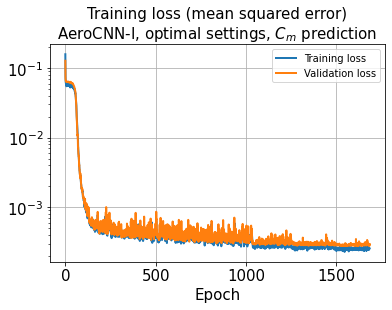

In [35]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

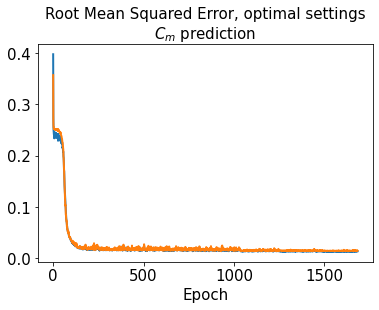

In [36]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

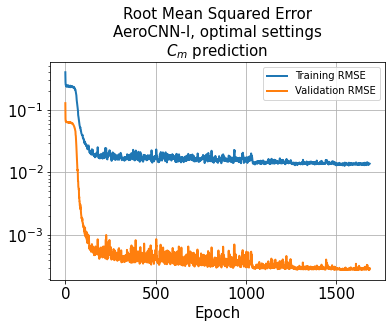

In [37]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [38]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 4ms/step - loss: 2.5034e-04 - rmse: 0.0135


In [39]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 5ms/step - loss: 2.8011e-04 - rmse: 0.0146


In [40]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 6ms/step - loss: 2.8152e-04 - rmse: 0.0146


In [41]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [42]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [43]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [44]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [45]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [46]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [47]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.03138261284636945
1.1831089557771277


In [48]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.032375272757184555
1.194594209075209


In [49]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.033291890185476986
1.2872015350439365


In [50]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [51]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [52]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "202301020unsteady_AeroCNN1_3Case(131415)Valid_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [53]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [54]:
os.chdir(storage_dir)

In [55]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [56]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [58]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [59]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [60]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [61]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

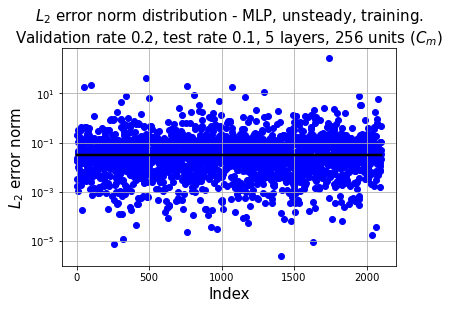

In [62]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

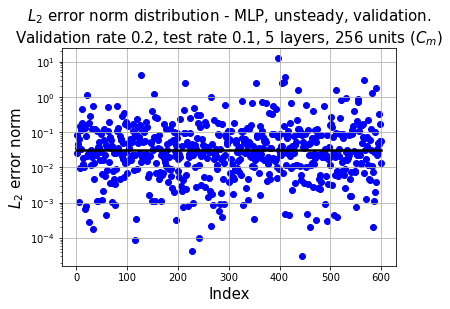

In [63]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

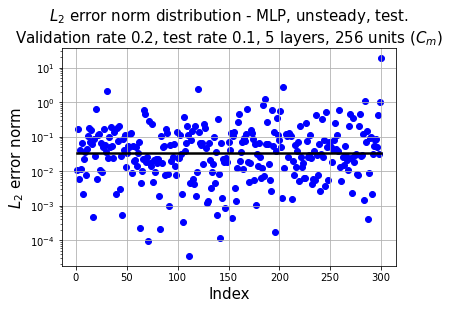

In [64]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [65]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 4ms/step


In [66]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [67]:
max(predicted)

array([0.9817619], dtype=float32)

In [68]:
print(l2_error(predicted, y))

0.03179571417560505


In [69]:
cm[2000]

array([0.00682824])

In [70]:
cm[1000]

array([0.0014248])

In [71]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [72]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [73]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [74]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [75]:
len(predicted[index_train])

2101

In [76]:
len(predicted[index_val])

600

In [77]:
len(predicted[index_test])

301

In [78]:
x_time += 10

L2 error of Cm: 0.0293


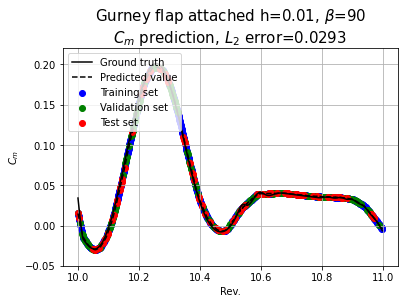

L2 error of Cm: 0.0439


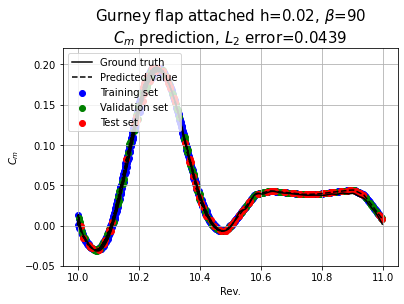

L2 error of Cm: 0.0150


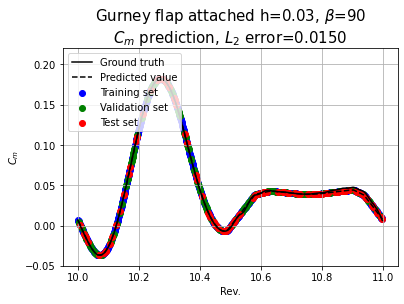

In [79]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [80]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0293


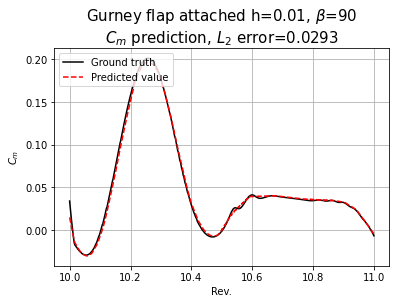

L2 error of Cm: 0.0439


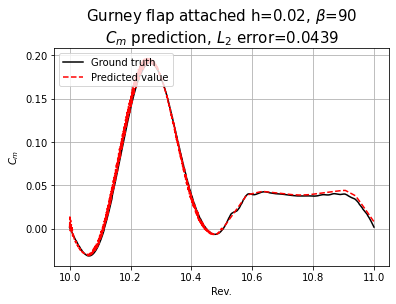

L2 error of Cm: 0.0150


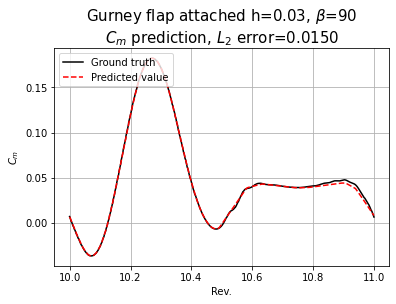

In [81]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0293


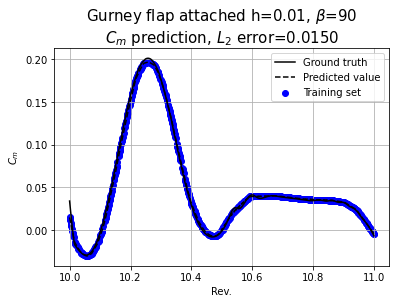

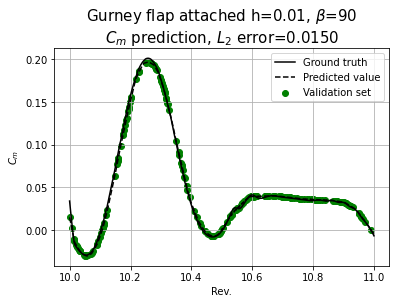

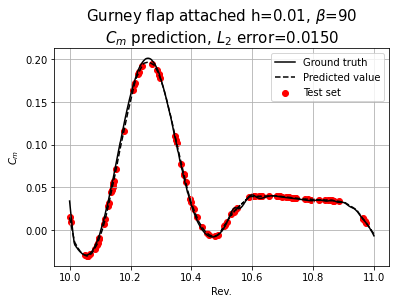

L2 error of Cm: 0.0439


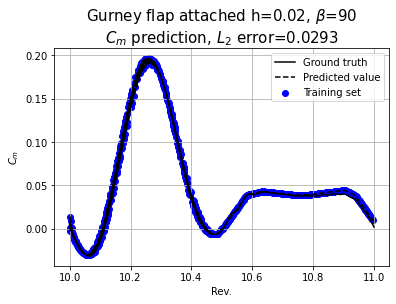

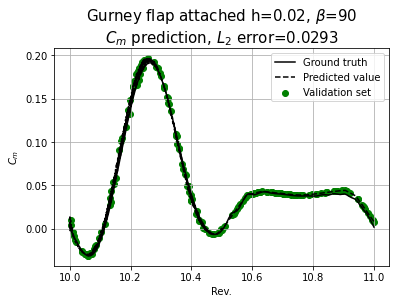

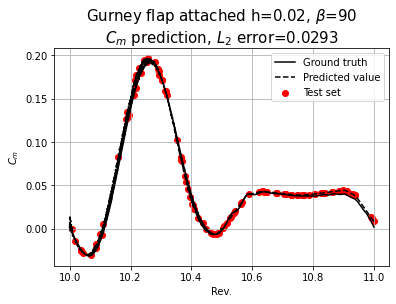

L2 error of Cm: 0.0150


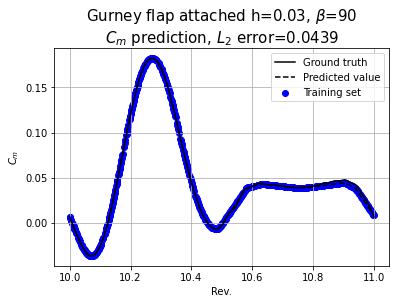

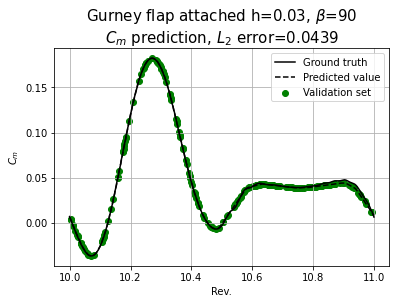

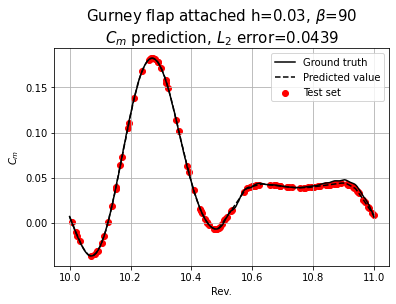

In [82]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

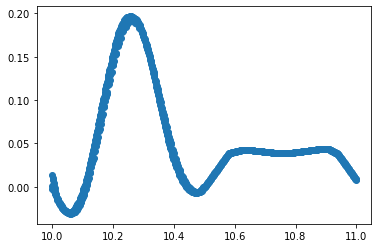

In [83]:
plt.scatter(t[:1000], denormalize(predicted[1000:2000]),  label='Predicted value')